### Protein Family Classification

In [2]:
import numpy as np
import pandas as pd
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.manifold import TSNE

In [3]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [4]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

#### Let's read the embedding matrix from the original article data.

In [6]:
table = pd.read_csv('data/protVec_100d_3grams_without_quotes.csv', sep='\t', header=None)
table = table.T
header = table.iloc[0] # grab the first row for the header
prot2vec = table[1:] # take the data less the header row
prot2vec.columns = header # set the header row as the df header
prot2vec["AAA"].head()

1    -0.17406
2   -0.095756
3    0.059515
4    0.039673
5   -0.375934
Name: AAA, dtype: object

2 most frequent families:

In [7]:
most_common_families = Counter(family_classification_metadata['FamilyID']).most_common(2)
most_common_families = [family for (family, count) in most_common_families]
family2num = {f: i for (i, f) in enumerate(most_common_families)}
family2num

{'Helicase_C': 1, 'MMR_HSR1': 0}

In [8]:
MAX_PROTEIN_LEN = 501
EMBED_LEN = 100

In [9]:
all_proteins = family_classification_sequences['Sequences']
all_families = family_classification_metadata['FamilyID']

selected_ids = [i for i in range(len(all_proteins)) 
                  if all_families[i] in family2num and len(all_proteins[i]) <= MAX_PROTEIN_LEN]

In [13]:
def embedding(protein):
    res = np.zeros(100)
    for i in range(0, (len(protein) - 3) // 3):
        try:
            res += prot2vec[protein[i*3: i*3 + 3]]
        except KeyError:
            res += prot2vec['<unk>']

    return res / ((len(protein) - 3) // 3)

#embedding(all_proteins[11])

In [14]:
selected_proteins = [embedding(p) for p in all_proteins[selected_ids]]

In [15]:
tsne = TSNE(n_components=2, random_state=42, angle=0.7, init='pca', n_iter=500)
XX = tsne.fit_transform(selected_proteins)

In [16]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])

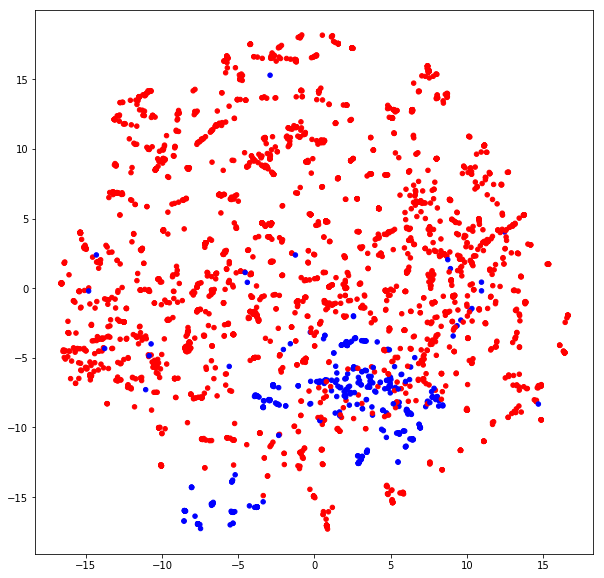

In [17]:
plt.figure(figsize=(10, 10))
colors = ['red', 'blue']
plt.scatter(tsne_df['x0'], tsne_df['x1'], c=[colors[family2num[f]] for f in all_families[selected_ids]], s=20);